In [1]:
from fastai.vision import *
import pandas as pd
import zipfile
from datetime import datetime
from shutil import copyfile

In [2]:
Path = Path('data/ships')

In [3]:
Path.ls()

[PosixPath('data/ships/Submission_RN50_05312019_0601.csv'),
 PosixPath('data/ships/test.csv'),
 PosixPath('data/ships/cleaned.csv'),
 PosixPath('data/ships/Submission_DN_05302019_2039.csv'),
 PosixPath('data/ships/.ipynb_checkpoints'),
 PosixPath('data/ships/Submission_05302019_1653.csv'),
 PosixPath('data/ships/export.pkl'),
 PosixPath('data/ships/Submission_RN_05302019_2303.csv'),
 PosixPath('data/ships/Submission_05262019_1956.csv'),
 PosixPath('data/ships/Submission_05272019_1606.csv'),
 PosixPath('data/ships/sample_submission.csv'),
 PosixPath('data/ships/train_images'),
 PosixPath('data/ships/Submission_05272019_1505.csv'),
 PosixPath('data/ships/test_images'),
 PosixPath('data/ships/Submission_05262019_1853.csv'),
 PosixPath('data/ships/Submission_RN_05302019_2204.csv'),
 PosixPath('data/ships/train.csv'),
 PosixPath('data/ships/Submission_05272019_0018.csv'),
 PosixPath('data/ships/Submission_05272019_1917.csv')]

In [4]:
# zip_ref = zipfile.ZipFile(path/'train.zip', 'r')
# zip_ref.extractall(path)
# zip_ref.close()

In [5]:
# for idx in range(0,len(train_labels)):
#     copyfile(f"{path}/images/{train_labels.loc[idx,'image']}", f"{path}/train_images/{train_labels.loc[idx,'image']}")

In [6]:
# for idx in range(0,len(test_labels)):
#     copyfile(f"{path}/images/{test_labels.loc[idx,'image']}", f"{path}/test_images/{test_labels.loc[idx,'image']}")

In [7]:
train_df = pd.read_csv(f"{Path}/train.csv")
train_df.shape

(6252, 2)

In [8]:
test_df = pd.read_csv(Path/'test.csv')
test_df.shape

(2680, 1)

In [9]:
submission = pd.read_csv(Path/'sample_submission.csv')
submission.shape

(2680, 2)

In [10]:
filepath, dirs, files = next(os.walk(f"{Path}/train_images"))
len(files)

6252

In [11]:
filepath, dirs, files = next(os.walk(f"{Path}/test_images"))
len(files)

2680

In [12]:
train_df.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [13]:
test_df.head()

,image
0,1007700.jpg
1,1011369.jpg
2,1051155.jpg
3,1062001.jpg
4,1069397.jpg


In [14]:
test_set = ImageList.from_df(test_df, path=Path, folder='test_images')

In [15]:
trfm = get_transforms(max_warp=0.
                     ,max_zoom=1.05
                     ,max_lighting=0.3
                     ,p_lighting=1
                     ,xtra_tfms=[symmetric_warp(magnitude=(-0.2,0.2))]
                     )

In [16]:
src = (ImageList.from_df(train_df, path=Path, folder='train_images')
            .split_by_rand_pct(0.1, seed=2019)
            .label_from_df()
            .add_test(test_set)
           )

In [17]:
train_set = (src.transform(trfm, size=256, padding_mode='zeros')
            .databunch(path='.', bs=16, device= torch.device('cuda'))
            .normalize(imagenet_stats)
            )

In [18]:
train_set.classes

[1, 2, 3, 4, 5]

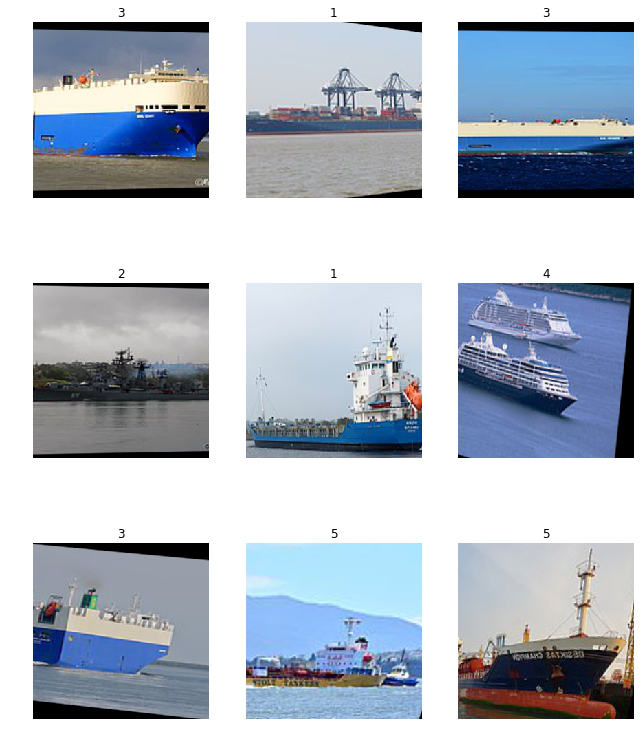

In [19]:
train_set.show_batch(rows=3, figsize=(9,11))

In [20]:
train_set.classes, train_set.c, len(train_set.train_ds), len(train_set.valid_ds)

([1, 2, 3, 4, 5], 5, 5627, 625)

In [21]:
learn = cnn_learner(train_set
                    , models.resnet152
                    , metrics=[error_rate
                             , accuracy
                             , FBeta(beta=1, average='weighted')
                              ]
                    , model_dir="/tmp/model/"
                    , opt_func=optim.SGD
                   )

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.00E-01


0.09999999999999999

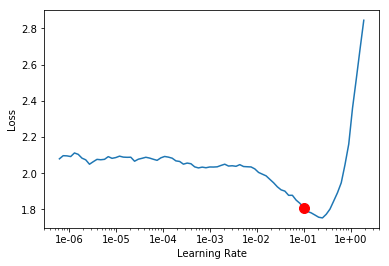

In [23]:
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr
min_grad_lr

In [24]:
learn.fit_one_cycle(5
                    , slice(min_grad_lr)
                    , wd=0.1
                    ) #0.956000, 0.955646

epoch,train_loss,valid_loss,error_rate,accuracy,f_beta,time
0,0.534683,0.323315,0.100800,0.899200,0.899699,02:31
1,0.449089,0.365522,0.113600,0.886400,0.886449,02:30
2,0.489012,0.280039,0.086400,0.913600,0.915473,02:30
3,0.379325,0.196638,0.068800,0.931200,0.931545,02:30
4,0.237075,0.142699,0.038400,0.961600,0.961820,02:30


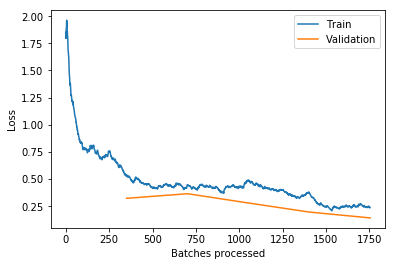

In [25]:
learn.recorder.plot_losses()

In [26]:
learn.save('stage-1-256-rn50')

fine tuning the whole model

In [27]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-06


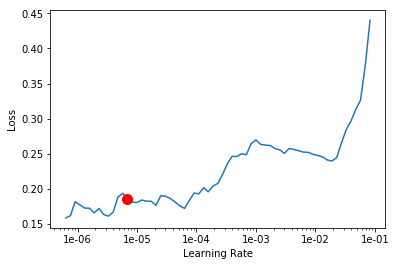

In [31]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [32]:
learn.fit_one_cycle(5, slice(1e-6, 1e-5), wd=0.1) #0.971200, 0.971196

epoch,train_loss,valid_loss,error_rate,accuracy,f_beta,time
0,0.228210,0.139662,0.043200,0.956800,0.956865,03:20
1,0.212455,0.137877,0.041600,0.958400,0.958464,03:20
2,0.224341,0.134017,0.036800,0.963200,0.963258,03:20
3,0.228069,0.142420,0.043200,0.956800,0.956888,03:20
4,0.218216,0.136405,0.040000,0.960000,0.960002,03:20


In [33]:
learn.save('stage-2-256-rn50')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06


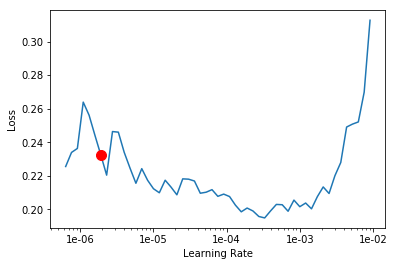

In [34]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [35]:
learn.fit_one_cycle(5, slice(1e-4), wd=0.1) #0.968871

epoch,train_loss,valid_loss,error_rate,accuracy,f_beta,time
0,0.197333,0.133574,0.038400,0.961600,0.961742,03:20
1,0.216368,0.130869,0.036800,0.963200,0.963258,03:20
2,0.190231,0.131201,0.038400,0.961600,0.961700,03:21
3,0.179146,0.138572,0.041600,0.958400,0.958491,03:21
4,0.189194,0.133958,0.038400,0.961600,0.961774,03:21


In [36]:
learn.save('stage-3-256-rn50')

In [37]:
interp = ClassificationInterpretation.from_learner(learn)

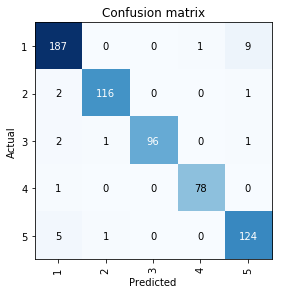

In [38]:
interp.plot_confusion_matrix()

In [39]:
interp.most_confused(min_val=2)

[(1, 5, 9), (5, 1, 5), (2, 1, 2), (3, 1, 2)]

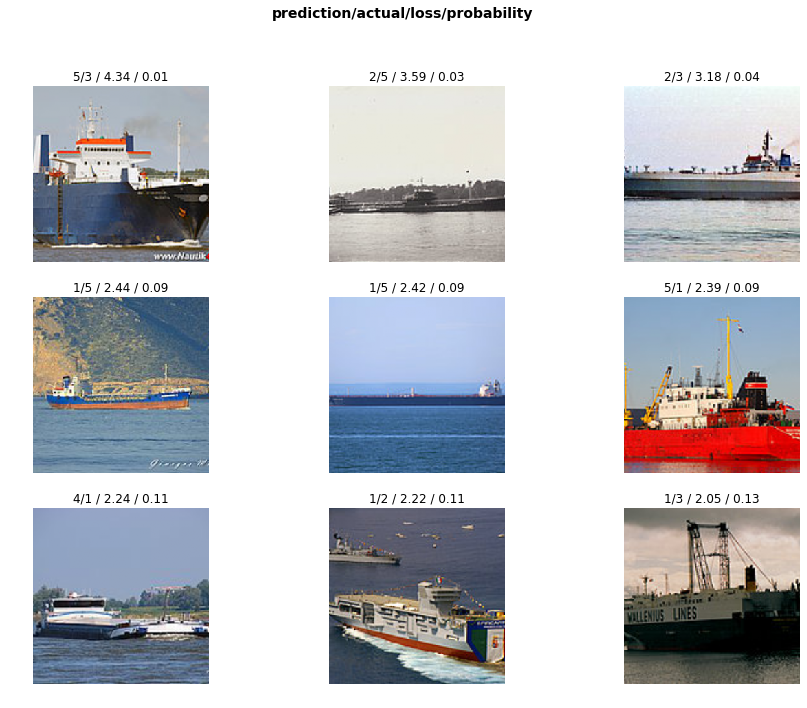

In [40]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=False)

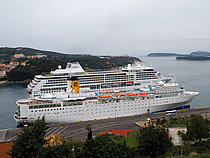

In [41]:
img = open_image(Path/'test_images/1097264.jpg')
img

In [42]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class, pred_idx, outputs

(Category 4,
 tensor(3),
 tensor([7.6172e-04, 4.6679e-04, 7.7462e-04, 9.9737e-01, 6.2441e-04]))

In [44]:
all_test_preds = []
for i in range(1, 4):
    learn.load('stage-' + str(i) + '-256-rn50')
    learn.model.eval();
    probs, y = learn.get_preds(ds_type=DatasetType.Test);
    all_test_preds.append(probs.numpy());

In [46]:
final = [train_set.classes[i] for i in np.argmax(np.mean(all_test_preds, 0), axis=1)]

In [47]:
final[:5]

[4, 4, 4, 2, 4]

In [48]:
submission['category'] = final

In [49]:
submission.head(10)

,image,category
0,1007700.jpg,4
1,1011369.jpg,4
2,1051155.jpg,4
3,1062001.jpg,2
4,1069397.jpg,4
5,1072861.jpg,4
6,1097264.jpg,4
7,1098763.jpg,2
8,1098766.jpg,2
9,1101145.jpg,4


In [51]:
file_timestamp = datetime.now().strftime('%m%d%Y_%H%M')
submission.to_csv(f'{Path}/Submission_RN50_{file_timestamp}.csv', index=False)